In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from src.llamma import LLAMMA
import matplotlib.pyplot as plt

In [14]:
class Oracle():
    def __init__(self):
        pass
    def price(self):
        return 1490

llamma = LLAMMA(100, 1500, Oracle(), 0)

In [15]:
n0 = llamma.active_band
llamma.deposit('Bob', 1000, n0+1, n0 + 8)
llamma.deposit('Alice', 767, n0+1, n0 + 3)

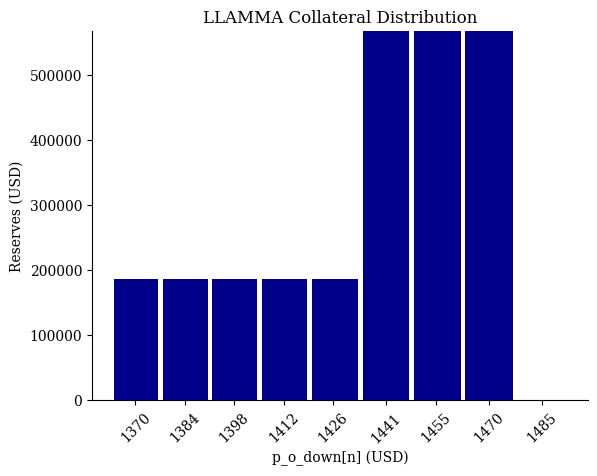

In [16]:
llamma.plot_reserves()

In [17]:
out_x, out_y = llamma.withdraw('Bob', 0.7)

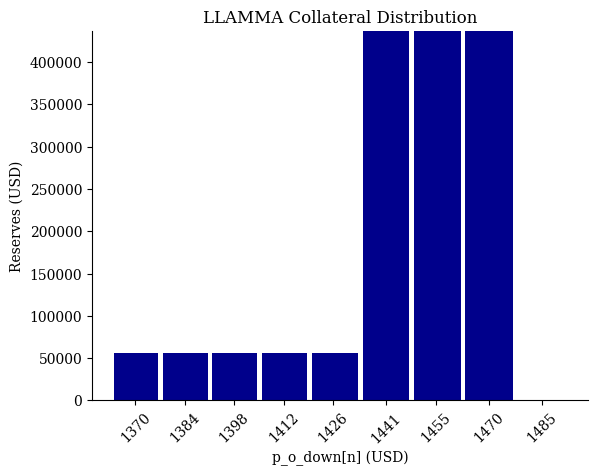

In [18]:
llamma.plot_reserves()

In [19]:
s = llamma._swap(500000, y_in=False)
s

Swap(
in_amount=500000
 out_amount=329.57538205290007
reserves=defaultdict(<function Swap.__init__.<locals>.<lambda> at 0x114480b80>, {0: [0.0, 0.0], 1: [444206.8919343874, 0], 2: [55793.108065612614, 256.7579512804332]})
admin_fee=0.0
n1=0
n2=2)

In [20]:
llamma.swap(500000, y_in=False)

(500000, 329.57538205290007)

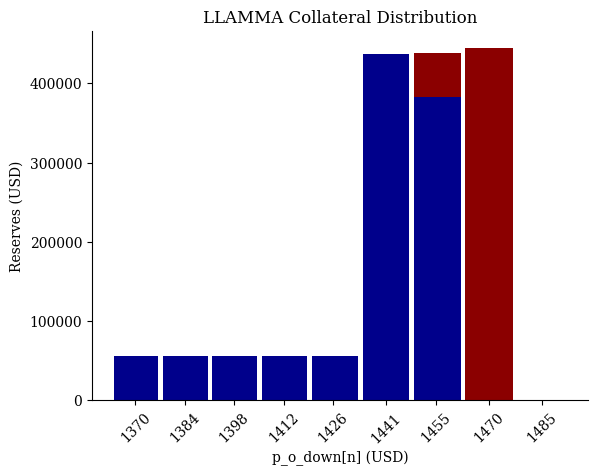

In [21]:
llamma.plot_reserves()